# Question 3: Cosine Similarity

In [1]:
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext.data as data
from models.attention import MultiHeadAttention
from models.embedder import Embedder, FeedForward, Norm, PositionalEncoder, get_clones
from transformers import GPT2Tokenizer

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Cosine Similarity Attention

* We're using cosine similarity as our new distance metric:

$\text{Cosim} = \frac{Q \cdot K^T}{\|Q\|\cdot\|K\|}$

* Cosine similarity focuses only on the orientation of the vectors, not their magnitude.
* The only major change here is that we're normalizing the vectors to unit length before taking their dot products.

In [3]:
def cosine_similarity_attention(q, k, v, d_k, mask=None, dropout=None):
    # Calculate norms
    q_norm = torch.norm(q, p=2, dim=-1, keepdim=True)  # Norm of queries
    k_norm = torch.norm(k, p=2, dim=-1, keepdim=True)  # Norm of keys

    dot_product = torch.matmul(q, k.transpose(-2, -1))

    # denominator (||q|| * ||k||)
    denominator = torch.matmul(q_norm, k_norm.transpose(-2, -1))

    # cosine similarity scores
    scores = dot_product / denominator

    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)

    scores = F.softmax(scores, dim=-1)

    if dropout is not None:
        scores = dropout(scores)

    output = torch.matmul(scores, v)
    return output

In [4]:
class CosineMultiHeadAttention(MultiHeadAttention):
    def forward(self, q, k, v, mask=None):
        bs = q.size(0)
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)

        k = k.transpose(1, 2)
        q = q.transpose(1, 2)
        v = v.transpose(1, 2)

        scores = cosine_similarity_attention(q, k, v, self.d_k, mask, self.dropout)
        concat = scores.transpose(1, 2).contiguous().view(bs, -1, self.d_model)
        output = self.out(concat)

        return output

## Decoder

We're using `CosineMultiHeadAttention` here.

In [5]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.attn_1 = CosineMultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)
        self.norm_2 = Norm(d_model)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, trg_mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x

In [6]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(DecoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)

    def forward(self, trg, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for layer in self.layers:
            x = layer(x, trg_mask)
        return self.norm(x)

## Transformer

In [7]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout, device):
        super().__init__()
        self.device = device
        self.vocab_size = vocab_size
        self.decoder = Decoder(vocab_size, d_model, N, heads, dropout)
        self.out = nn.Linear(d_model, vocab_size)

    def forward(self, trg, trg_mask):
        d_output = self.decoder(trg, trg_mask)
        output = self.out(d_output)
        return output

## No-Peak Mask

In [8]:
def nopeak_mask(size, device):
    np_mask = ~torch.triu(torch.ones((1, size, size), device=device), diagonal=1).bool()
    return np_mask

## Data Feeder

### Tokenizer

In [9]:
TOKENIZER = GPT2Tokenizer.from_pretrained("gpt2")

In [10]:
TOKENIZER.add_special_tokens(
    {"pad_token": "[PAD]", "bos_token": "<sos>", "eos_token": "<eos>"}
)
TOKENIZER.pad_token_id, TOKENIZER.bos_token_id, TOKENIZER.eos_token_id

(50257, 50258, 50259)

### Tokenization

In [11]:
def load_and_tokenize_file(file_path, tokenizer):
    with open(file_path, "r", encoding="utf-8") as file:
        lines = [line.strip() for line in file if line.strip()]

    # Tokenize each line with special tokens and store tokens
    all_token_ids = []
    for line in lines:
        modified_line = f"<sos> {line} <eos>"  # Add special tokens
        tokens = tokenizer.tokenize(modified_line)
        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        all_token_ids.extend(token_ids)

    return all_token_ids

### Batching and Creating Sequences

In [12]:
class BatchGenerator:
    def __init__(self, data, seq_len=512, batch_size=32, pad_token_id=0):
        self.data = data
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.pad_token_id = pad_token_id
        self.total_data_len = len(data)
        self.steps_per_epoch = (
            self.total_data_len + self.batch_size * self.seq_len - 1
        ) // (self.seq_len * self.batch_size)

    def generate(self):
        start_index = 0
        while True:
            # Calculate the end index of the batch
            end_index = start_index + self.batch_size * self.seq_len
            if end_index > self.total_data_len:
                # Handle end of array with padding if not enough data to complete the batch
                residual_data = self.data[start_index : self.total_data_len]
                padding_needed = end_index - self.total_data_len
                padded_data = np.full(padding_needed, self.pad_token_id, dtype=int)
                batch_data = np.concatenate((residual_data, padded_data))
                start_index = (
                    self.total_data_len
                )  # Set start_index to total_data_len to end generation
            else:
                batch_data = self.data[start_index:end_index]
                start_index += self.batch_size * self.seq_len

            # Reshape batch data to the required dimensions
            batch_data = np.array(batch_data).reshape(self.batch_size, self.seq_len)
            yield batch_data

            if start_index >= self.total_data_len:
                break

## Training

In [13]:
def get_model(vocab_size, d_model=512, N=6, heads=8, dropout=0.1, device="cpu"):
    model = Transformer(vocab_size, d_model, N, heads, dropout, device)
    model.to(device)
    return model

In [14]:
def train_model(
    model, train_generator, valid_generator, optimizer, device, epochs, print_every=50
):
    train_losses = []
    train_perplexities = []
    valid_losses = []
    valid_perplexities = []

    for epoch in range(epochs):
        # Training Phase
        model.train()
        total_train_loss = 0
        intermediate_train_loss = 0
        start = time.time()

        # Adjust to use the generator
        for i, batch in enumerate(train_generator.generate()):
            batch_tensor = torch.tensor(batch).to(device)
            no_peak_mask = nopeak_mask(batch_tensor.size(1), device)

            # https://github.com/SamLynnEvans/Transformer/blob/master/Batch.py#L20
            preds = model(batch_tensor, no_peak_mask)
            preds = preds[:, :-1, :]  # Exclude the last time step predictions
            ys = (
                batch_tensor[:, 1:].contiguous().view(-1)
            )  # Targets shifted by one position

            optimizer.zero_grad()
            loss = F.cross_entropy(
                preds.reshape(-1, preds.size(-1)),
                ys,
                ignore_index=TOKENIZER.pad_token_id,
            )
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            intermediate_train_loss += loss.item()

            if (i + 1) % print_every == 0:
                p = int(100 * (i + 1) / train_generator.steps_per_epoch)
                avg_loss = intermediate_train_loss / print_every
                print(
                    f"{int((time.time() - start) // 60)}m: epoch {epoch + 1} [{p}%] Train loss = {avg_loss:.3f}",
                    end="\r",
                )
                intermediate_train_loss = 0

            if (i + 1) == train_generator.steps_per_epoch:
                break  # Stop after processing all steps per epoch

        avg_train_loss = total_train_loss / train_generator.steps_per_epoch
        train_perplexity = torch.exp(torch.tensor(avg_train_loss)).item()
        train_losses.append(avg_train_loss)
        train_perplexities.append(train_perplexity)

        # Validation Phase
        model.eval()
        total_valid_loss = 0
        with torch.no_grad():
            for i, batch in enumerate(valid_generator.generate()):
                batch_tensor = torch.tensor(batch).to(device)
                no_peak_mask = nopeak_mask(batch_tensor.size(1), device)

                preds = model(batch_tensor, no_peak_mask)
                preds = preds[:, :-1, :]
                ys = batch_tensor[:, 1:].contiguous().view(-1)

                loss = F.cross_entropy(
                    preds.reshape(-1, preds.size(-1)),
                    ys,
                    ignore_index=TOKENIZER.pad_token_id,
                )
                total_valid_loss += loss.item()

                if (i + 1) == valid_generator.steps_per_epoch:
                    break  # Stop after processing all steps per epoch

        avg_valid_loss = total_valid_loss / valid_generator.steps_per_epoch
        valid_perplexity = torch.exp(torch.tensor(avg_valid_loss)).item()
        valid_losses.append(avg_valid_loss)
        valid_perplexities.append(valid_perplexity)

        print(
            f"Epoch {epoch + 1}: Train loss = {avg_train_loss:.3f}, Train Perplexity = {train_perplexity:.3f}"
        )
        print(
            f"Epoch {epoch + 1}: Validation loss = {avg_valid_loss:.3f}, Validation Perplexity = {valid_perplexity:.3f}"
        )

    return train_losses, train_perplexities, valid_losses, valid_perplexities

In [15]:
train_tokens = load_and_tokenize_file("data/wiki2.train.txt", TOKENIZER)
train_batch_generator = BatchGenerator(
    train_tokens, seq_len=512, batch_size=25, pad_token_id=TOKENIZER.pad_token_id
)

valid_tokens = load_and_tokenize_file("data/wiki2.valid.txt", TOKENIZER)
valid_batch_generator = BatchGenerator(
    valid_tokens, seq_len=512, batch_size=25, pad_token_id=TOKENIZER.pad_token_id
)

* We're using the same hyperparameters as earlier as they work well.
* We're also limit our training to 10 epochs because our previous model shows best results at 10.

In [16]:
vocab_size = len(TOKENIZER)
model = get_model(vocab_size, d_model=512, N=6, heads=8, dropout=0.1, device=DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
results = train_model(
    model, train_batch_generator, valid_batch_generator, optimizer, DEVICE, epochs=10, print_every=50
)

Epoch 1: Train loss = 6.360, Train Perplexity = 578.483
Epoch 1: Validation loss = 5.182, Validation Perplexity = 178.088
Epoch 2: Train loss = 5.377, Train Perplexity = 216.360
Epoch 2: Validation loss = 4.987, Validation Perplexity = 146.446
Epoch 3: Train loss = 4.954, Train Perplexity = 141.765
Epoch 3: Validation loss = 4.951, Validation Perplexity = 141.324
Epoch 4: Train loss = 4.702, Train Perplexity = 110.170
Epoch 4: Validation loss = 4.898, Validation Perplexity = 133.993
Epoch 5: Train loss = 4.537, Train Perplexity = 93.454
Epoch 5: Validation loss = 4.856, Validation Perplexity = 128.536
Epoch 6: Train loss = 4.420, Train Perplexity = 83.057
Epoch 6: Validation loss = 4.813, Validation Perplexity = 123.130
Epoch 7: Train loss = 4.316, Train Perplexity = 74.875
Epoch 7: Validation loss = 4.850, Validation Perplexity = 127.753
Epoch 8: Train loss = 4.233, Train Perplexity = 68.898
Epoch 8: Validation loss = 4.859, Validation Perplexity = 128.835
Epoch 9: Train loss = 4.158,

```python
Epoch 1: Train loss = 6.360, Train Perplexity = 578.483
Epoch 1: Validation loss = 5.182, Validation Perplexity = 178.088
Epoch 2: Train loss = 5.377, Train Perplexity = 216.360
Epoch 2: Validation loss = 4.987, Validation Perplexity = 146.446
Epoch 3: Train loss = 4.954, Train Perplexity = 141.765
Epoch 3: Validation loss = 4.951, Validation Perplexity = 141.324
Epoch 4: Train loss = 4.702, Train Perplexity = 110.170
Epoch 4: Validation loss = 4.898, Validation Perplexity = 133.993
Epoch 5: Train loss = 4.537, Train Perplexity = 93.454
Epoch 5: Validation loss = 4.856, Validation Perplexity = 128.536
Epoch 6: Train loss = 4.420, Train Perplexity = 83.057
Epoch 6: Validation loss = 4.813, Validation Perplexity = 123.130
Epoch 7: Train loss = 4.316, Train Perplexity = 74.875
Epoch 7: Validation loss = 4.850, Validation Perplexity = 127.753
Epoch 8: Train loss = 4.233, Train Perplexity = 68.898
Epoch 8: Validation loss = 4.859, Validation Perplexity = 128.835
Epoch 9: Train loss = 4.158, Train Perplexity = 63.914
Epoch 9: Validation loss = 4.786, Validation Perplexity = 119.879
Epoch 10: Train loss = 4.079, Train Perplexity = 59.092
Epoch 10: Validation loss = 4.799, Validation Perplexity = 121.418
```

* It's interesting to note that adding the normalization in the cosine distance, marginally slows down the training.
* Due to the norm, we had to reduce our batch size to accomodate additional attention weights in our memory. This further slowed down our training.
* Furthermore, our perplexities here are poorer than they were for the model using the standard attention.

In [18]:
train_losses, train_perplexities, valid_losses, valid_perplexities = results

### Training Results

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [20]:
epochs = list(range(1, len(train_losses) + 1))
train_data = pd.DataFrame(
    {
        "Epoch": epochs,
        "Train Loss": train_losses,
        "Train Perplexity": train_perplexities,
    }
)

valid_data = pd.DataFrame(
    {
        "Epoch": epochs,
        "Validation Loss": valid_losses,
        "Validation Perplexity": valid_perplexities,
    }
)

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


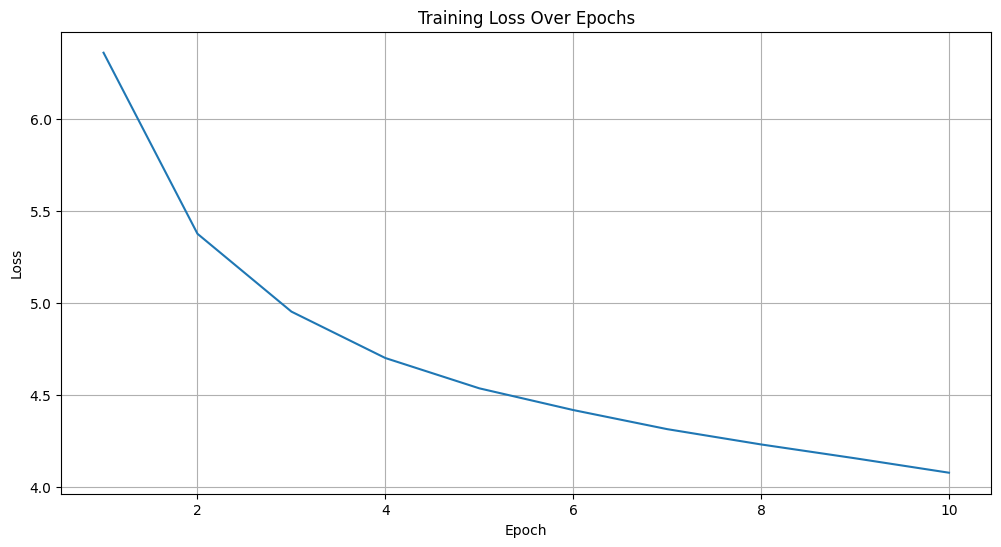

In [21]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=train_data, x="Epoch", y="Train Loss")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


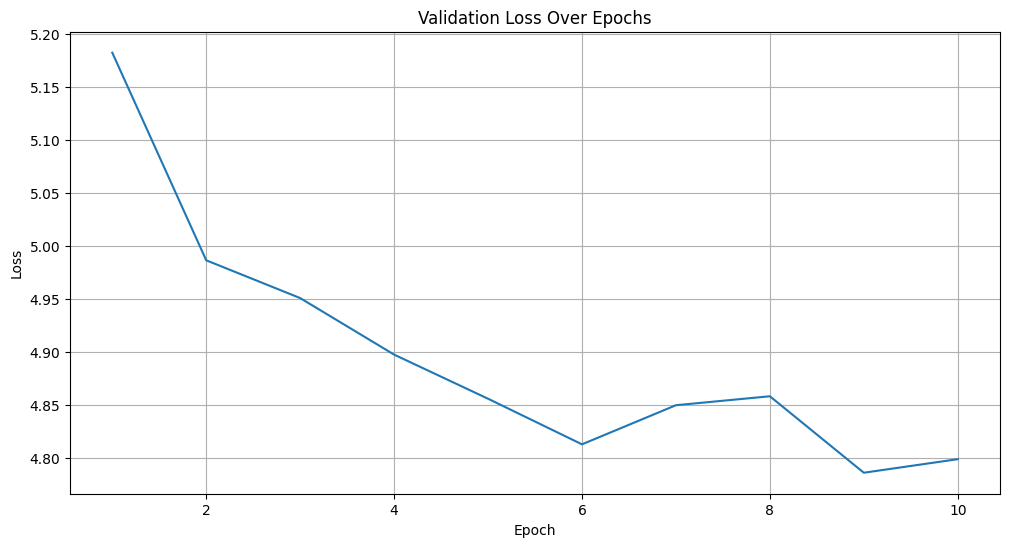

In [22]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=valid_data, x="Epoch", y="Validation Loss")
plt.title("Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


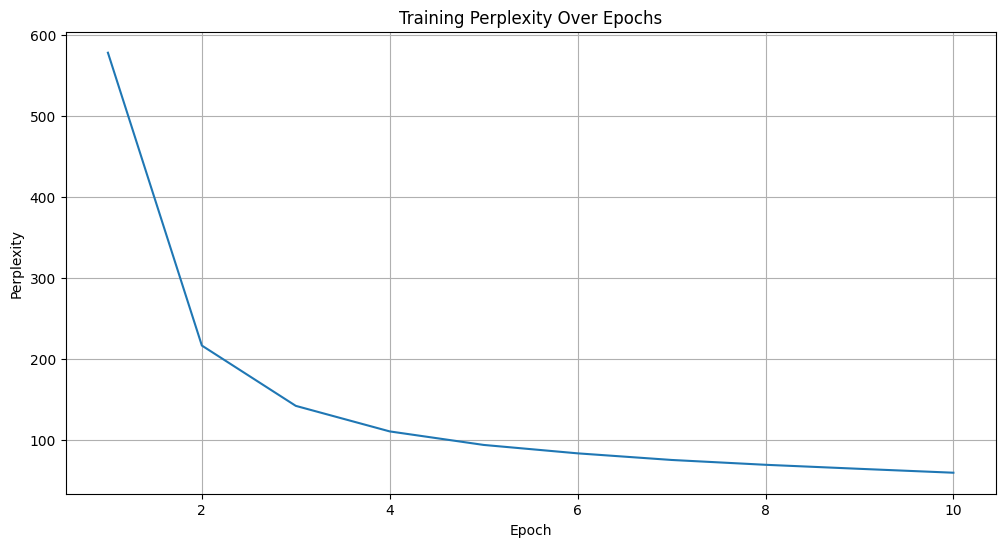

In [23]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=train_data, x="Epoch", y="Train Perplexity")
plt.title("Training Perplexity Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.grid(True)
plt.show()

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


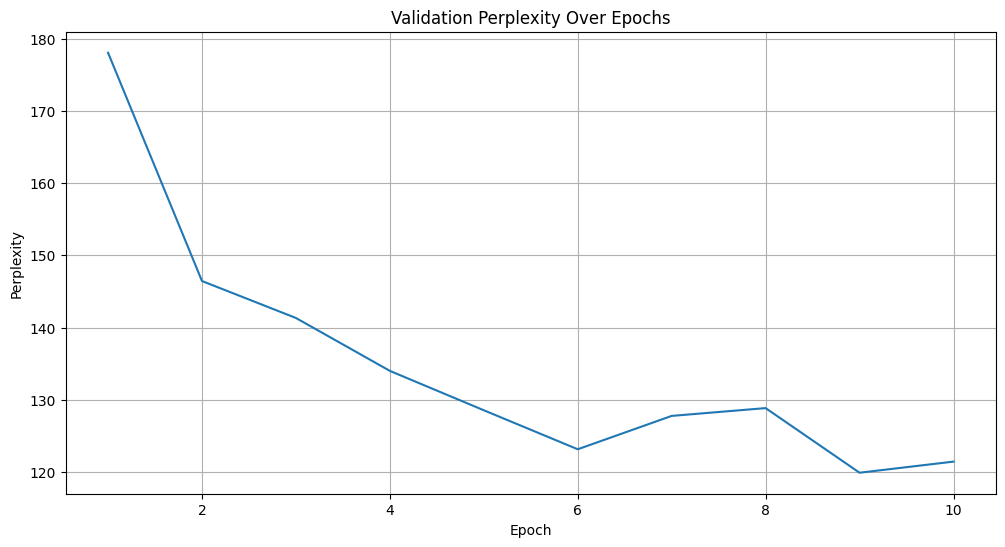

In [24]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=valid_data, x="Epoch", y="Validation Perplexity")
plt.title("Validation Perplexity Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.grid(True)
plt.show()

## Testing

In [25]:
torch.save(model.state_dict(), "model_wgts/model_weights_q3.pth")

In [26]:
saved_model = get_model(
    vocab_size, d_model=512, N=6, heads=8, dropout=0.1, device=DEVICE
)

In [27]:
saved_model.load_state_dict(
    torch.load("model_wgts/model_weights_q3.pth", map_location=DEVICE)
)

<All keys matched successfully>

In [28]:
test_tokens = load_and_tokenize_file("data/wiki2.test.txt", TOKENIZER)
test_batch_generator = BatchGenerator(
    train_tokens, seq_len=512, batch_size=25, pad_token_id=TOKENIZER.pad_token_id
)

In [29]:
def test_model(model, generator, device):
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(generator.generate()):
            batch_tensor = torch.tensor(batch).to(device)
            no_peak_mask = nopeak_mask(batch_tensor.size(1), device)

            preds = model(batch_tensor, no_peak_mask)
            preds = preds[:, :-1, :]
            ys = batch_tensor[:, 1:].contiguous().view(-1)

            loss = F.cross_entropy(
                preds.reshape(-1, preds.size(-1)),
                ys,
                ignore_index=TOKENIZER.pad_token_id,
            )
            total_test_loss += loss.item()

            if (i + 1) == generator.steps_per_epoch:
                break

    avg_test_loss = total_test_loss / generator.steps_per_epoch
    test_perplexity = torch.exp(torch.tensor(avg_test_loss)).item()

    return avg_test_loss, test_perplexity

In [30]:
loss, perplexity = test_model(saved_model, test_batch_generator, DEVICE)

In [31]:
print("Average Loss:", loss)

Average Loss: 4.039313656588395


In [32]:
print("Perplexity:", perplexity)

Perplexity: 56.78736114501953


Our perplexity is twice as bad as the model with the dot product attention.